In [14]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import shuffle

import cv2
import albumentations as A
from albumentations.pytorch import *

from pycocotools.coco import COCO
from pycocotools.mask import toBbox

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

device = 'cuda'

In [15]:

class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

In [16]:
class RanaSet(Dataset):
    def __init__(self,im_folder):

        self.im_folder = im_folder
        with open('annos.json','r') as file:
            self.annos = json.load(file)
        self.annos['images'] = shuffle(self.annos['images'])
        self.coco = COCO('annos.json')

        self.transform = A.Compose([A.RandomBrightnessContrast(p=0.4,brightness_limit=0.2, contrast_limit=0.2),
                                    A.SafeRotate(p=0.7,limit=15),
                                    A.GaussNoise(p=0.4),
                                    A.Resize(693,520),
                                    A.ToFloat(max_value=255),
                                    ToTensorV2()])


    def getImID(self,idx):
        return self.annos['images'][idx]['id']

    def getAnno(self,idx):
        id = self.getImID(idx)
        return next(anno for anno in self.annos['annotations'] if anno['image_id']==id)

    def getImage(self,idx):
        id = self.getImID(idx)
        filename = next(item['file_name'] for item in self.annos['images'] if item['id']==id )
        im = cv2.imread(self.im_folder + filename)
        return im
        
    def imshow(self,im,boxes=None):
        im2show = np.transpose( 255*im.cpu().detach().numpy(), [1,2,0] ).astype(np.uint8).copy()
        if boxes is not None:
            for box in boxes:
                box = [int(x.item()) for x in box]
                p1 = (box[0],box[1])
                p2 = (box[2],box[3])
                print( p2 )
                cv2.rectangle(im2show,p1,p2,(0,0,255),1)

        cv2.imshow('im',im2show)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        

    def __len__(self):
        return len(self.annos['images'])

    def __getitem__(self, idx):

        im = self.getImage(idx)
        anno = self.getAnno(idx)
        pantalla = self.coco.annToMask(anno)

        transformed = self.transform(image=im,mask=pantalla)
        im = preprocess(transformed['image'])
        im = torch.unsqueeze(im,0).to(device)
        pantalla = torch.unsqueeze(transformed['mask'],0)
        return im,pantalla

ranaset = RanaSet(im_folder='images/')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [17]:
# ===================================================
# ===================== MODEL =======================
# ===================================================

weights = torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT
model = torchvision.models.segmentation.fcn_resnet50(num_classes=2).to(device)
preprocess = weights.transforms()
dice_loss = BinaryDiceLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=1e-4)


In [18]:
losses_train, losses_valid = [],[]
train_len = 200

100%|██████████| 200/200 [00:47<00:00,  4.20it/s]


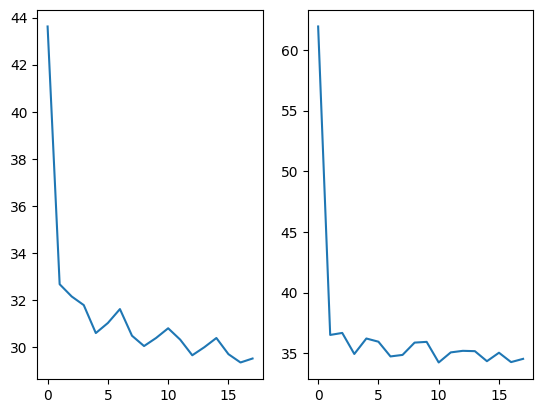

In [20]:
e_loss = 0
for e in range(4):
    for i in tqdm(range(train_len)):

        model.train()
        optimizer.zero_grad()
        im,mask_true = ranaset[i]
        
        mask_pred = model(im)
        mask_pred = mask_pred['out'].cpu()[:,1]
        loss = dice_loss(mask_pred,mask_true)
        loss.backward()
        optimizer.step()

        e_loss += loss.item()

        if i%50==0 and (i!=0 or e!=0):
            losses_train.append(e_loss)
            e_loss = 0

            e_loss_valid = 0
            model.eval()
            with torch.no_grad():
                for j in range(train_len,len(ranaset)):
                    im,mask_true = ranaset[j]
                    mask_pred = model(im)
                    mask_pred = mask_pred['out'].cpu()[:,1]
                    loss = dice_loss(mask_pred,mask_true)
                    e_loss_valid += loss.item()
            losses_valid.append(e_loss_valid)

fig,ax = plt.subplots(1,2)
ax[0].plot(losses_train)
ax[1].plot(losses_valid)
plt.show()

In [21]:
# SAVE MODEL
torch.save(model.state_dict(), 'ranavision_segmentation.pt')

In [22]:
# LOAD MODEL
model.load_state_dict(torch.load('ranavision_segmentation.pt', map_location=device))

<All keys matched successfully>

In [23]:
# ===================================================
# ================== VIZUALICE ======================
# ===================================================
i = 203

model.eval()
im,stuff =
model()